In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;  
}

<IPython.core.display.Javascript object>

In [2]:
import sys
sys.path.append('/Users/af/Work/code/mcmc/build')
#sys.path.append('/Users/af/Work/code/mcmc/debug')

import mcmc
#help(mcmc)
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
from datetime import datetime,timedelta
giturl_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

corona_cases_df=pd.read_csv(giturl_deaths, index_col=[0,1,2,3])  
#   use first four columns as multiindex




country_official_list = (corona_cases_df.index.get_level_values('Country/Region').values)

wanted_countries = ['China', 'Korea','Italy', 'France', 'US', 'Spain']

countries_list = [np.unique(np.array([s for s in country_official_list if cou in s])) 
                                                 for cou in wanted_countries]
countries_list = np.array(countries_list).flatten()
countries_list.sort()
print(countries_list)


cases_percountry = {}
df_dict = {}
for country in countries_list:
    cou = corona_cases_df.loc[pd.IndexSlice[:, country], :].sum()
    cases_percountry[country] = cou[cou > 0]
    datesformat = [datetime.strptime(da, '%m/%d/%y') 
                   for da in cases_percountry[country].index]
    
    df_dict[country] = pd.DataFrame(cases_percountry[country], 
                                    columns=['Cases'], index=datesformat)
    df_dict[country]['DayCount'] = np.arange(1, 
                                             cases_percountry[country].shape[0]+1)
    
   

['China' 'France' 'Italy' 'Korea, South' 'Spain' 'US']


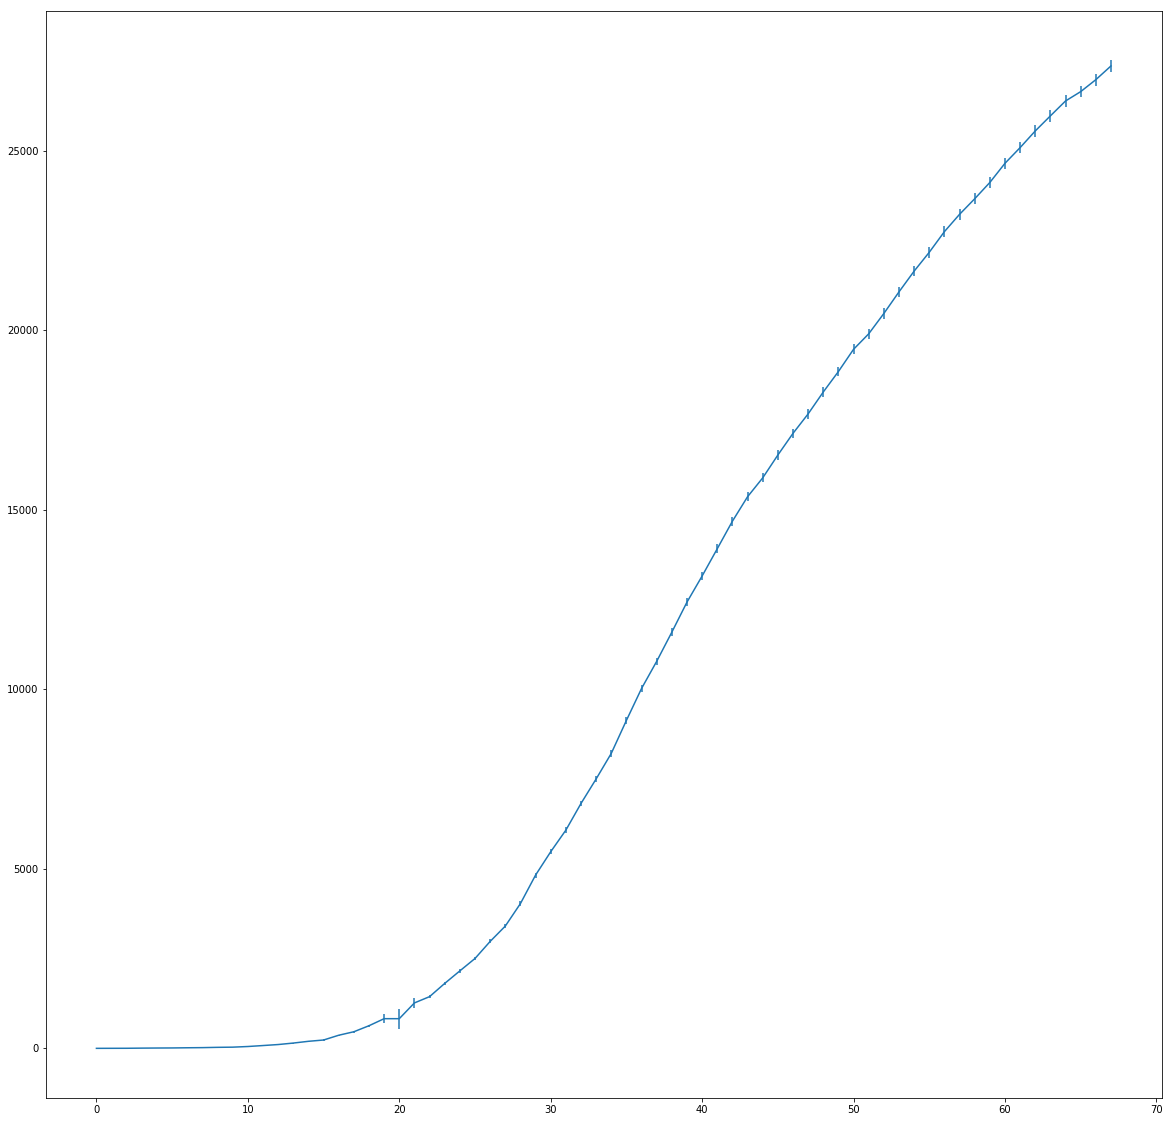

In [4]:
 
country = 'Korea, South'
country = 'Spain'
country = 'Italy'

#print(df_dict[country].index)
#print(df_dict['Italy']['Cases'])  #print cases every three days

# for country in countries_list:
#     print(country)
#     dates=df_dict[country].index
#     plt.semilogy(dates, np.array(list(df_dict[country]['Cases'].values)), label=country)
#     plt.legend(loc='lower right')
#     plt.tick_params(rotation=45, labelsize=12)
#     #plt.ylabel(casestr, fontsize=14)
# plt.xlim([dates[0]-np.timedelta64(3,'D'), dates[-1]+np.timedelta64(10,'D')])
# plt.show()

if country == 'Italy':
    nPop = 60260000
    icuBeds = 7500
if country == 'Spain':
    nPop = 46722000
    icuBeds = 3500
if country == 'France':
    nPop = 67000000
    icuBeds = 7000
    
nPredictDays = 1
maxdelay = 70

#testdays = np.arange(60)

#starting at 21 feb 

#print(np.array(list(df_dict[country]['Cases'].values)))



#deaths_data = deaths_data[:-4]




deaths_data = np.array(list(df_dict[country]['Cases'].values))
#deaths_data = np.array([1,2,3,7,10,12,17,21,29,34,52,79,107,148,197,233,366,463,631,827,827,1266,1441,1809,2158,2503,2978,3405,4032,4825,5476,6077,6820,7503,8215,9134,10023,10779,11591,12428,13155,13915, 14681, 15362 ])
#nPop/(1+np.exp(-(testdays-20)*0.2))*0.0015

deaths_past = np.zeros(maxdelay + deaths_data.size)
deaths_past[maxdelay:] = deaths_data
#keep the relative error low at 1%. if all measurements were independent it would be low.
#but errors even out in time mostly - here we assume a tiny fraction of cases does not 
#besides the constant 

#shot noise: every delta has sigma = sqrt(delta). day i var is cumsum of sigma^2=delta, so the original total. 
#constant unnoticed deaths are fitted for
#assume additional 10% attribution error in the numbers of each day, which however are supposed to be cancelled by anticorrelated erros in 
#the next 2 days instead of accumulating 

shotnoise = np.sqrt(deaths_data)
deaths_error = shotnoise

perday = np.diff(deaths_data)
deaths_error[1:] += 0*0.05*perday 

#unnoticed = 3*np.ones(deaths_data.shape)
#unnoticed[14:] = 0
 #np.cumsum(unnoticed) + shotnoise

if country == 'Italy':
    deaths_error[19] += 100
    deaths_error[20] += 250
    deaths_error[21] += 100
    
    
time_past = np.arange(deaths_past.size)-maxdelay
time_data = np.arange(deaths_data.size)
time_all = np.arange(deaths_past.size+nPredictDays)-maxdelay


#plt.plot(time_past, deaths_past)
plt.figure(figsize=(20,20))
plt.errorbar(time_data, deaths_data, deaths_error)



deathdata = np.zeros((2, deaths_data.size))
deathdata[0, :] = deaths_data
deathdata[1, :] = deaths_error

if country == 'Italy':
    discontdays = np.array([1, 9, 12, 29]) #removed 32 
    discontvals = np.array([0.99,0.3,0.3,0.2]) 
if country == 'Spain':
    discontdays = np.array([8, 10, 25]) #removed 32 
    discontvals = np.array([1,0.6,0.2])
if country == 'France':
    discontdays = np.array([22, 28, 30, 31]) #removed 32 
    discontvals = np.array([1,0.8,0.2, 0.1])

discontdata = np.zeros((3, discontdays.size))
discontdata[0, :] = discontdays
discontdata[1, :] = discontvals
discontdata[2, :] = discontvals # > 0 means sample this (else fixed)
#discontdata[2, 1] = -1         # < 0 means fix 

data = mcmc.DiseaseData(deathdata,  discontdata)

In [5]:
params = mcmc.DiseaseParams()
params.probLethalDailyWhenSeriousUntreated = 0.4
params.probSerious = 0.045 #unknown, higher for older population - should be possible to extract from Diamond Princess. 
#I think about 30 were serious... 30/700 would then be upper limit, so at most 5% for old people. 
#Conistency check: 6(factor below)*11(dead on diamond princess) = 66... okay, more than 30. So 10% serious for old people.
# this number is between 0.02 and 0.1. need to line search max likelihood

params.probLethal = params.probSerious*0.13 #out of 50~49 serious cases, 7 dead in Aachen study https://www.aerzteblatt.de/archiv/213454
params.probAsymp = 0.375
params.timeIncub = 6  #chinese like studies...
params.timeIncubSigma = 4

#obained to match median 4, IQR 7 from Aachen study https://www.aerzteblatt.de/archiv/213454
params.timeMildToSerious = 7.1 
params.timeMildToSeriousSigma = 13

#Drosten study https://www.medrxiv.org/content/10.1101/2020.03.05.20030502v1 
#: 9 patients, all virus present after 5 days of symptoms. Let's say then that chance shorter ~ 10%. 
# seroconversion early week 2 progressive decrease in viral load in samples. 10 days most gone. 
#let's take lognormal with 5 at 10% CDF and 10 at 90% CDF 
params.timeMildDuration = 7.4 
params.timeMildDurationSigma = 2

# Aachen Median acht Tage (IQR 5–11) for all, including most that did not die. 
# This is longer with larger spread than the recovered group. We choose Median 8.6, IQR 6.6 to get 
params.timeSeriousToDeath = 10
params.timeSeriousToDeathSigma = 6

# less important: 
# Aachen Median 7 Tage [IQR 6–11])
params.timeSeriousToRecovered = 8
params.timeSeriousToRecoveredSigma = 4.5

params.proxyTincub = 8
params.proxyTinfec = 14

#data.initialBetaMild = 3.38/4
#data.initialBetaHigh = 5.05/4
data.initialMild0 = 4500+1000
data.initialHigh0 = 5200+1000
data.initialDelay = 40.0-10
data.initialMissedDeaths = 10

data.fixBehaviorInAdvance = 10


covid = mcmc.DiseaseSpread(data, params, nPop, icuBeds, 100, maxdelay, nPredictDays)
covid.computeR = False

state = mcmc.State()
state.add(covid)
smooth = mcmc.SmoothnessPrior("behavior", 50, deaths_data.size-data.fixBehaviorInAdvance)
state.add(smooth)

state.sharedDependencyMaxDepth = 2

Tinit = 40

target = mcmc.TempTarget(Tinit)
target.set_posterior(state)

chain = mcmc.Chain(target, 0)
chain.computeMean = False
chain.recordSamples = False
#chain.run(250000,0,200,500)


nChains = 4
nSteps = 3
nThinning = 1000 
nBurnin = 0
#nTrials = 100000

cm0 = mcmc.ChainManager(target, nChains)
cm0.run_all_adjust(nThinning*nSteps*2, 2000, nThinning)

#chain.run(nThinning*nSteps*nChains*2, 20, 2000, nThinning)


# covid = mcmc.DiseaseSpread(data, params, nPop, icuBeds, 100, maxdelay, nPredictDays)
# covid.computeR = True
# state = mcmc.State()
# state.add(covid)
# smooth = mcmc.SmoothnessPrior("behavior", 50, deaths_data.size-data.fixBehaviorInAdvance)
# #state.add(smooth)



# target = mcmc.AdvCoolingTarget(15, 5)
# target.minOscillations = 8
# target.maxPeriodLength = 6
# target.set_posterior(state)
# chain = mcmc.Chain(target, 0)
# chain.computeMean = False
# chain.recordSamples = True
# chain.run(0,0,5000,20)


91.07077275006921
4


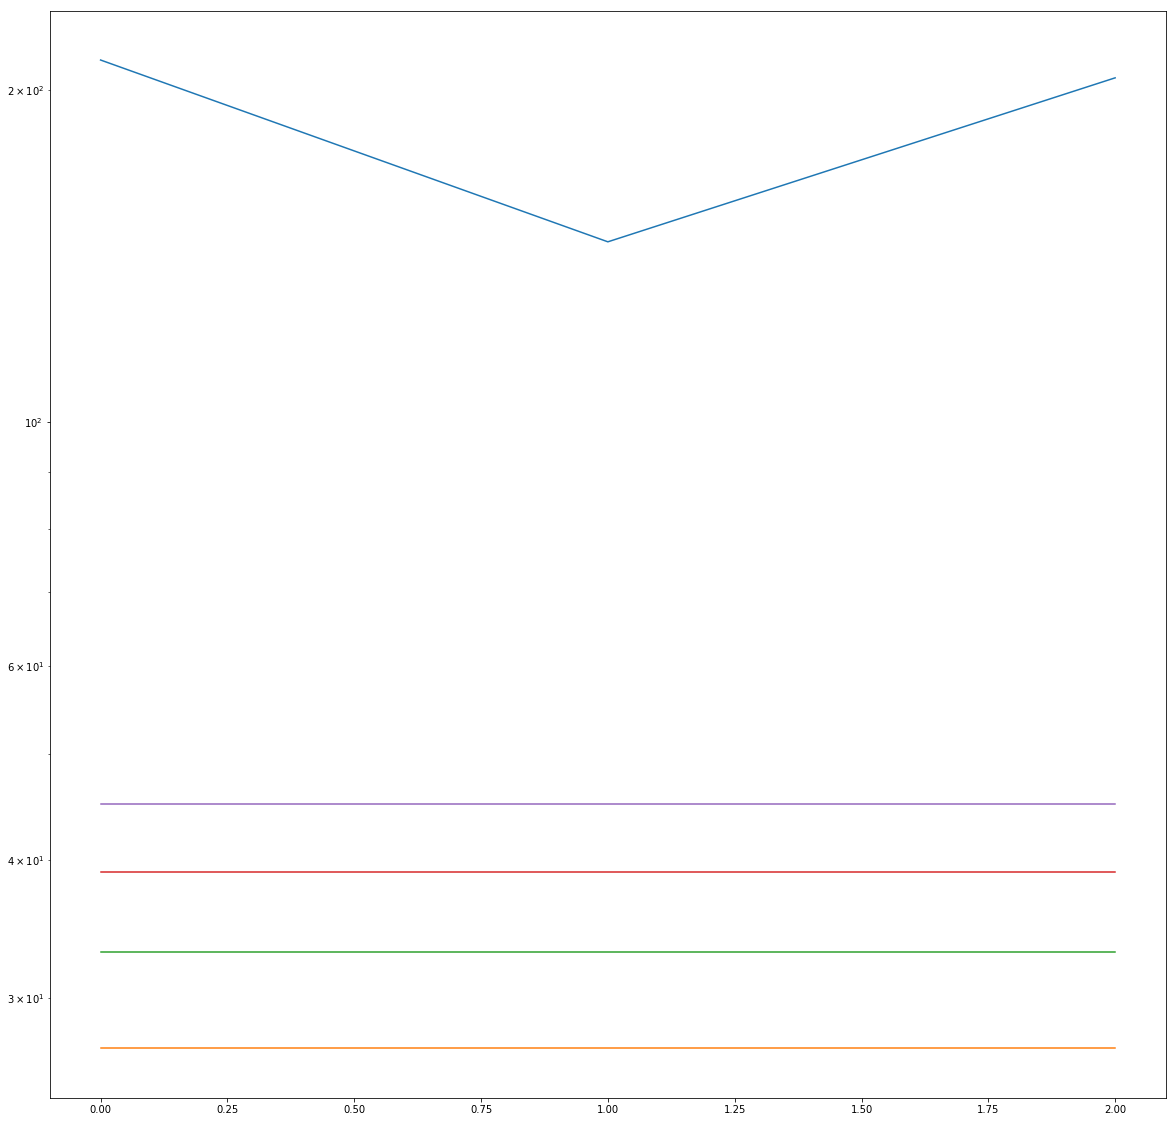

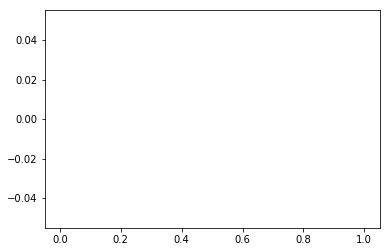

In [7]:
chain = cm0.get_chain(2)
plt.figure(figsize=(20,20))
print(Tinit*np.min(-chain.get_loglikes()))
print(np.argmin(-chain.get_loglikes()))
plt.semilogy(-Tinit*chain.get_loglikes()[5:])
plt.semilogy(0*chain.get_loglikes()[5:] + 27)
plt.semilogy(0*chain.get_loglikes()[5:] + 33)
plt.semilogy(0*chain.get_loglikes()[5:] + 39)
plt.semilogy(0*chain.get_loglikes()[5:] + 45)
plt.show()
plt.hist(chain.get_samples("delay"), 40)
plt.show()
# print(state.getInitialConditions())
# ics = state.getInitialConditions()
# print(state.loglike())
# state.setInitialConditions(state.getInitialConditions())
# print(state.loglike())

In [ ]:
s = state
alpha = 0.90
T = Tinit*alpha
t2  = mcmc.TempTarget(T)
t2.set_posterior(s)

#cm = mcmc.ChainManager(chain, t2, nChains)
cm = mcmc.ChainManager(cm0.get_all_chains(), t2, nChains)
cm.run_all(nThinning*nSteps, nThinning, np.sqrt(alpha))
    
while T > 1/alpha: 
    print(T)
    T *= alpha
    t2  = mcmc.TempTarget(T)
    t2.set_posterior(s)
    cm = mcmc.ChainManager(cm.get_all_chains(), t2, nChains)
    cm.run_all(nThinning*nSteps, nThinning, np.sqrt(alpha))

T = 1 

t2  = mcmc.TempTarget(T)
t2.set_posterior(s)
cm = mcmc.ChainManager(cm.get_all_chains(), t2, nChains)
cm.run_all(nThinning*nSteps*2, nThinning, np.sqrt(alpha))


36.0
32.4
29.16
26.244

In [9]:
print(data.initialMild0)
nPredictDays = 360
covid = mcmc.DiseaseSpread(data, params, nPop, icuBeds, 100, maxdelay, nPredictDays)
covid.computeR = True

state = mcmc.State()
state.add(covid)
smooth = mcmc.SmoothnessPrior("behavior", 50, deaths_data.size-data.fixBehaviorInAdvance)
state.add(smooth)
state.sharedDependencyMaxDepth = 2
state.init()

cm.reevaluate_all(state, 0, True, False)

5500.0


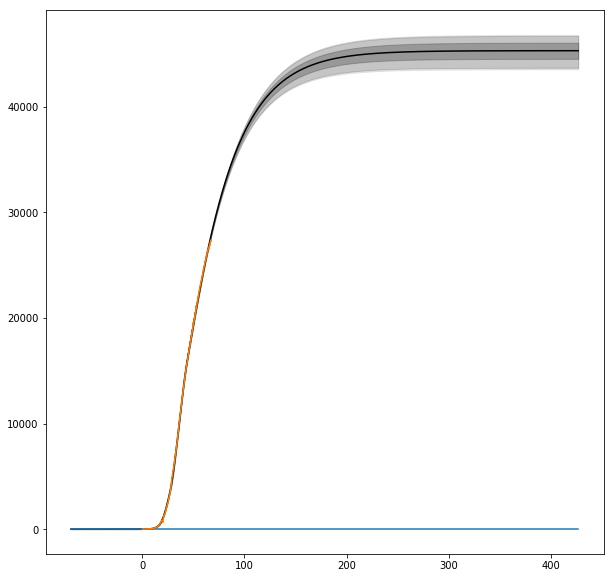

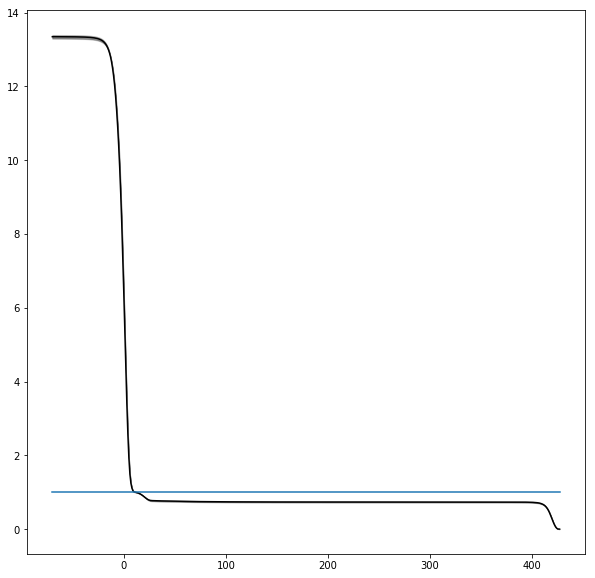

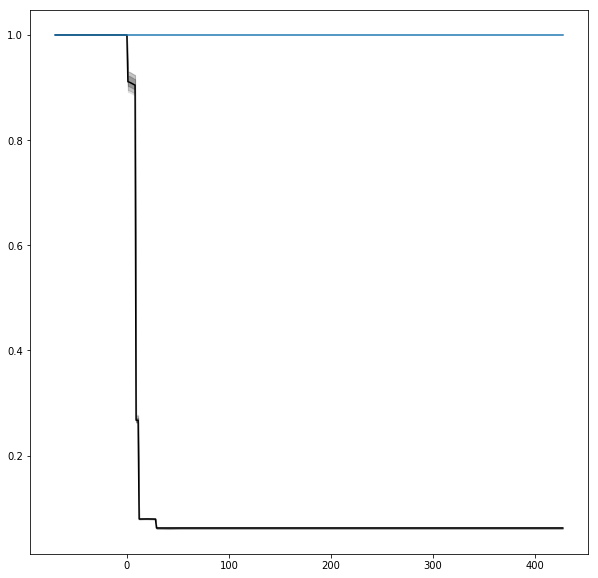

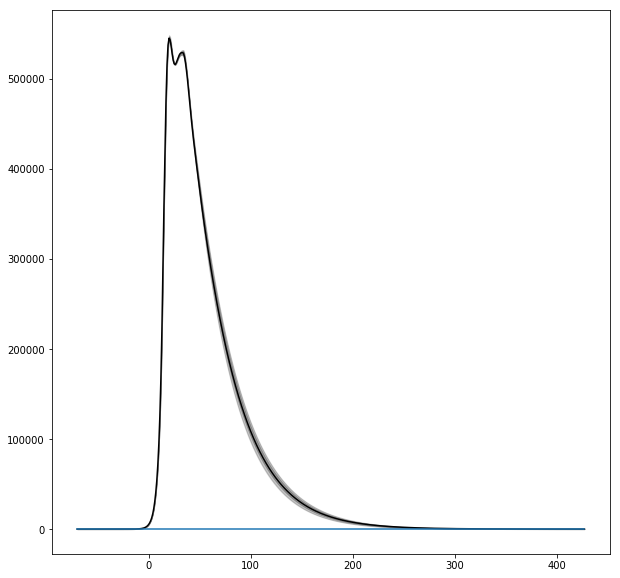

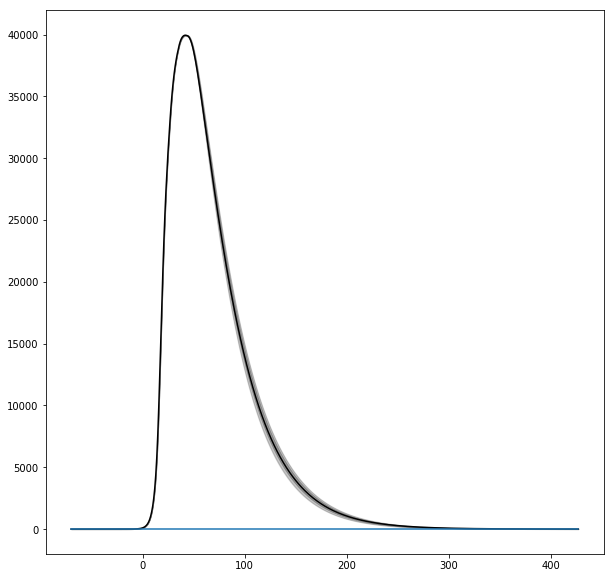

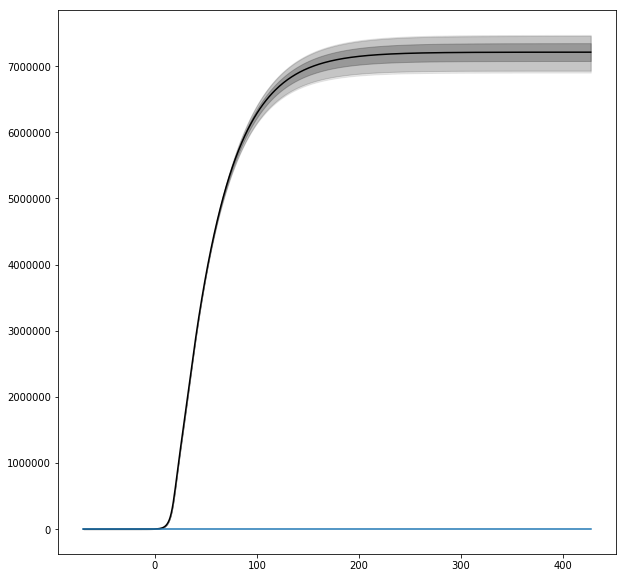

In [10]:
def myplot(name): 

    plt.figure(figsize=(10,10))
    
    samples = cm.get_chain(0).get_samples(name)[:,:]

    for i in np.arange(1, nChains):
        samples = np.vstack((samples, cm.get_chain(i).get_samples(name)[:,:]))
    
    
    y = np.median(samples,0)
    lower1 = np.percentile(samples, (100-68.27)/2, axis=0)
    lower2 = np.percentile(samples, (100-95.45)/2, axis=0)
    lower3 = np.percentile(samples, (100-99.73)/2, axis=0)
    upper1 = np.percentile(samples, 100-(100-68.27)/2, axis=0)
    upper2 = np.percentile(samples, 100-(100-95.45)/2, axis=0)
    upper3 = np.percentile(samples, 100-(100-99.73)/2, axis=0)
    
    time_all = np.arange(deaths_past.size+nPredictDays)-maxdelay

    if name == "behavior":
        time_all = np.arange(deaths_data.size-data.fixBehaviorInAdvance)
       
    
    plt.plot(time_all, y, 'k')
    fc = '#333333'
    ec = fc # '#000000'

    plt.plot(time_all,np.ones(time_all.shape))
    plt.fill_between(time_all, lower1, upper1, alpha=0.3, facecolor=fc, edgecolor=ec, antialiased=True)
    plt.fill_between(time_all, lower2, upper2, alpha=0.2, facecolor=fc, edgecolor=ec, antialiased=True)
    plt.fill_between(time_all, lower3, upper3, alpha=0.1, facecolor=fc, edgecolor=ec, antialiased=True)
    
    if name == "dead":   
        plt.errorbar(time_data, deaths_data, deaths_error)
        
    plt.show()
    
myplot("dead")
myplot("R")
myplot("totalBehavior")
myplot("mild")
myplot("serious")
myplot("recovered")

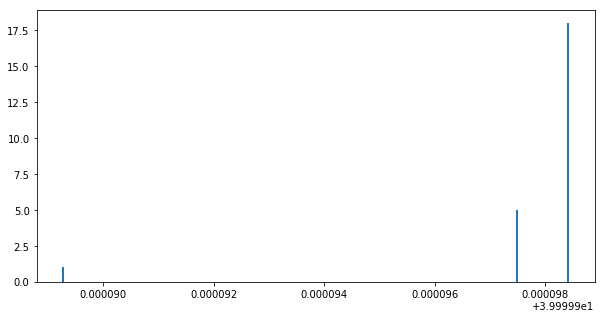

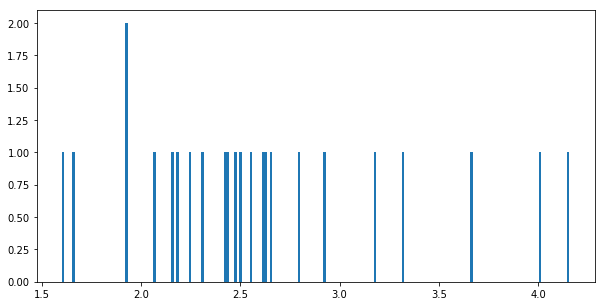

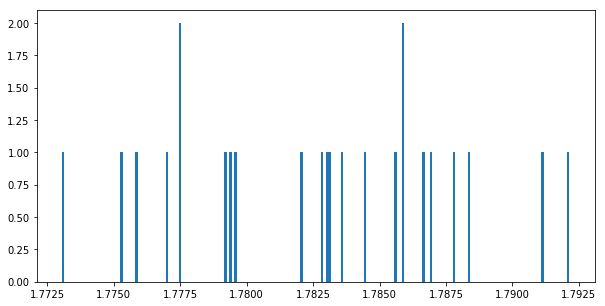

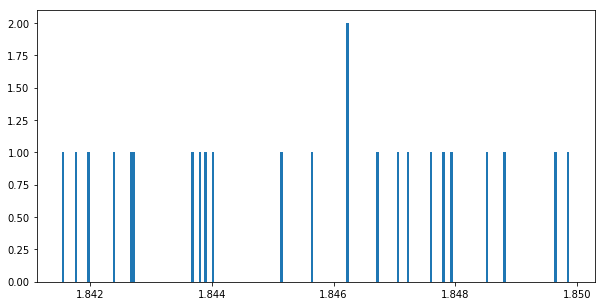

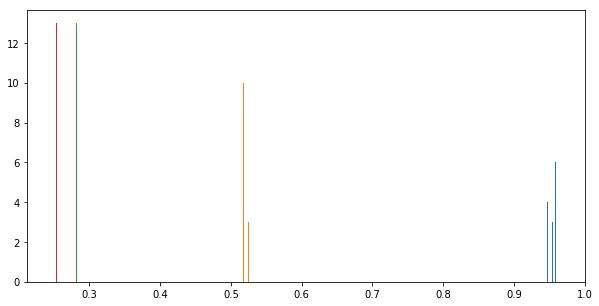

In [11]:
#chain.recordSamples = True
#chain.reevaluate(s, 0)

#print(chain.get_samples("delay"))
def myhist(name): 
    plt.figure(figsize=(10,5))
    

    samples = cm.get_chain(0).get_samples(name)



    for i in np.arange(1, nChains):
        samples = np.vstack((samples, cm.get_chain(i).get_samples(name)))
 

    plt.hist(samples, 200)
    plt.show()
    
myhist("delay")
myhist("missedDeaths")
myhist("betaMild")
myhist("betaHigh")
myhist("discontinuousVals")

In [11]:
chain.recordSamples = True
chain.reevaluate(state, 0)

(array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([28.81715975, 29.24366885, 29.67017795, 30.09668704, 30.52319614,
        30.94970523, 31.37621433, 31.80272343, 32.22923252, 32.65574162,
        33.08225071, 33.50875981, 33.93526891, 34.361778  , 34.7882871 ,
        35.21479619, 35.64130529, 36.06781439, 36.49432348, 36.92083258,
        37.34734167, 37.77385077, 38.20035987, 38.62686896, 39.05337806,
        39.47988715, 39.90639625, 40.33290535, 40.75941444, 41.18592354,
        41.61243263, 42.03894173, 42.46545083, 42.89195992, 43.31846902,
        43.74497812, 44.17148721, 44.59799631, 45.0245054 , 45.4510145 ,
        45.8775236 ]),
 array([3025.41720936, 3118.92062234, 3212.42403532, 3305.9274483 ,
        3399.43086128, 3492.93427426, 3586.43768724, 3679.94110022,
        

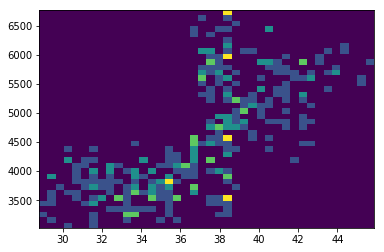

In [13]:
plt.hist2d(chain.get_samples("delay")[1:,0], chain.get_samples("mild0")[1:,0], 40)
#print(chain.get_loglikes()*40)
#print(chain.get_samples("delay")[chain.get_loglikes()*40 > -400], 0)

In [44]:
target  = mcmc.TempTarget(1.0)

covid = mcmc.DiseaseSpread(data, params, nPop, icuBeds, 100, maxdelay, 1)
covid.computeR = False

state = mcmc.State()
state.add(covid)
smooth = mcmc.SmoothnessPrior("behavior", 50, deaths_data.size-data.fixBehaviorInAdvance)
state.add(smooth)
# state.init()

# state.setInitialConditions(ics)
# state.eval()
# print(ics)
# print(state.loglike())



target.set_posterior(state)
nChains = 5
cm = mcmc.ChainManager(chain, target, nChains)


In [67]:
cm.run_chains(100000, 1000, 0.8)



In [68]:
cm.reevaluate_all(state, 0, True, False)

# print(state.getInitialConditions())
# print(state.loglike())
# state.setInitialConditions(ics)
# state.eval()
# print(ics)
# print(state.loglike())


# state.setInitialConditions(ics)
# state.eval()
# print(ics)
# print(state.loglike())

In [69]:
for i in range(nChains):

    print("first {} last {}".format(cm.get_chain(i).get_samples("delay")[0],cm.get_chain(i).get_samples("delay")[-1]))


first [37.64866917] last [37.57762292]
first [37.67967268] last [37.61930222]
first [37.67919189] last [37.60454216]
first [37.59308601] last [37.56718186]
first [37.53692996] last [37.53434409]


In [ ]:
plt.figure(figsize=(20,20))
print(np.min(-chain.getLoglikes()))
print(np.argmin(-chain.getLoglikes()))
plt.semilogy(-chain.getLoglikes())


In [ ]:
plt.figure(figsize=(20,20))
print(np.min(-chain.getLoglikes()))
print(np.argmin(-chain.getLoglikes()))
plt.semilogy(-chain.getLoglikes())


In [ ]:
plt.plot(time_all[0:120], chain.getSamples("dead")[-1,0:120])
plt.show()
plt.semilogy(time_all[0:120], chain.getSamples("mildlyInfectious")[-1,0:120])
plt.show()
plt.plot(time_all[0:120], chain.getSamples("totalBehavior")[-1,0:120])

In [ ]:
plt.plot(time_all[0:120], chain.getSamples("dead")[-1,0:120])
plt.show()
plt.semilogy(time_all[0:120], chain.getSamples("mildlyInfectious")[-1,0:120])
plt.show()
plt.plot(time_all[0:120], chain.getSamples("totalBehavior")[-1,0:120])

In [ ]:
begin = 0
end = -1
nBin = 30

plt.hist(chain.getSamples("betaMild")[begin:end], nBin)
plt.show()
plt.hist(chain.getSamples("betaHigh")[begin:end], nBin)
plt.show()

plt.hist(chain.getSamples("mild0")[begin:end], nBin)
plt.show()
plt.hist(chain.getSamples("high0")[begin:end], nBin)
plt.show()

plt.hist(chain.getSamples("delay")[begin:end], nBin)
plt.show()
plt.hist(chain.getSamples("missedDeaths")[begin:end], nBin)
plt.show()

plt.hist(chain.getSamples("discontinuousVals")[begin:end, 0], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousVals")[begin:end, 1], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousVals")[begin:end, 2], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousVals")[begin:end, 3], nBin)
plt.show()

plt.hist(chain.getSamples("discontinuousValsBeta")[begin:end, 0], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousValsBeta")[begin:end, 1], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousValsBeta")[begin:end, 2], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousValsBeta")[begin:end, 3], nBin)
plt.show()

In [ ]:
begin = 0
end = -1

nBin = 30

plt.hist(chain.getSamples("betaMild")[begin:end], nBin)
plt.show()
plt.hist(chain.getSamples("betaHigh")[begin:end], nBin)
plt.show()

plt.hist(chain.getSamples("mild0")[begin:end], nBin)
plt.show()
plt.hist(chain.getSamples("high0")[begin:end], nBin)
plt.show()

plt.hist(chain.getSamples("delay")[begin:end], nBin)
plt.show()
plt.hist(chain.getSamples("missedDeaths")[begin:end], nBin)
plt.show()

plt.hist(chain.getSamples("discontinuousVals")[begin:end, 0], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousVals")[begin:end, 1], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousVals")[begin:end, 2], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousVals")[begin:end, 3], nBin)
plt.show()

plt.hist(chain.getSamples("discontinuousValsBeta")[begin:end, 0], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousValsBeta")[begin:end, 1], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousValsBeta")[begin:end, 2], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousValsBeta")[begin:end, 3], nBin)
plt.show()


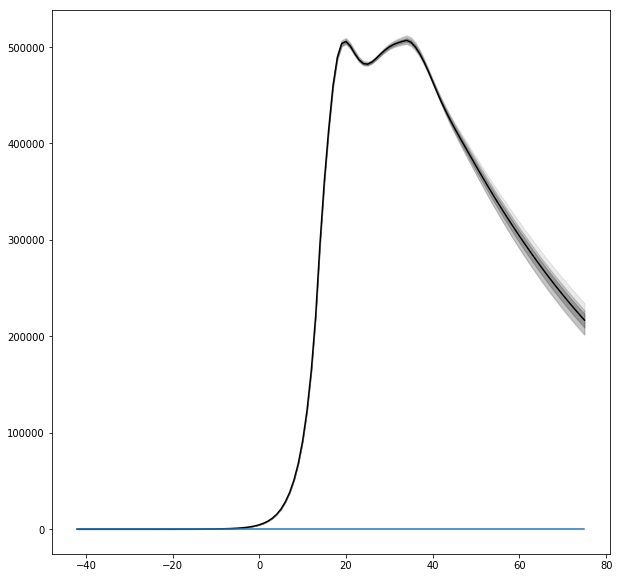

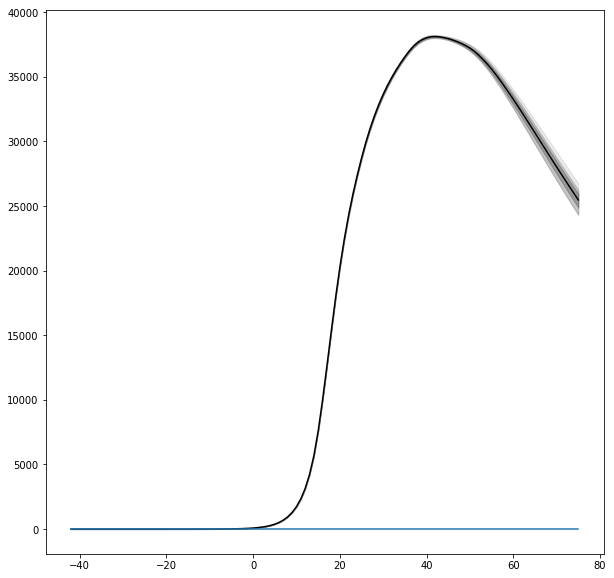

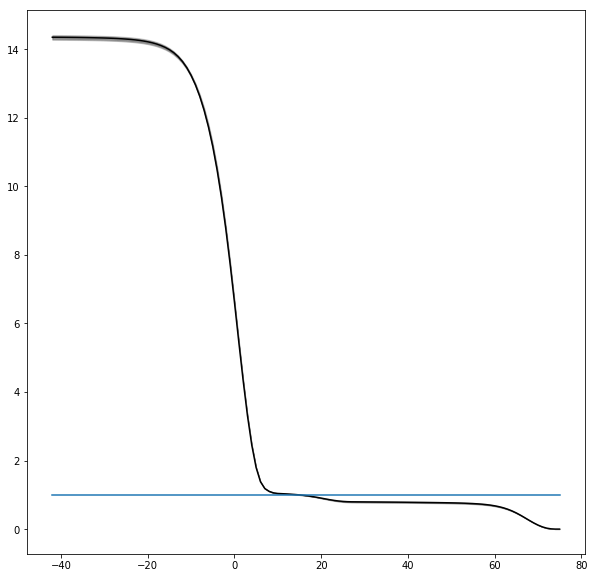

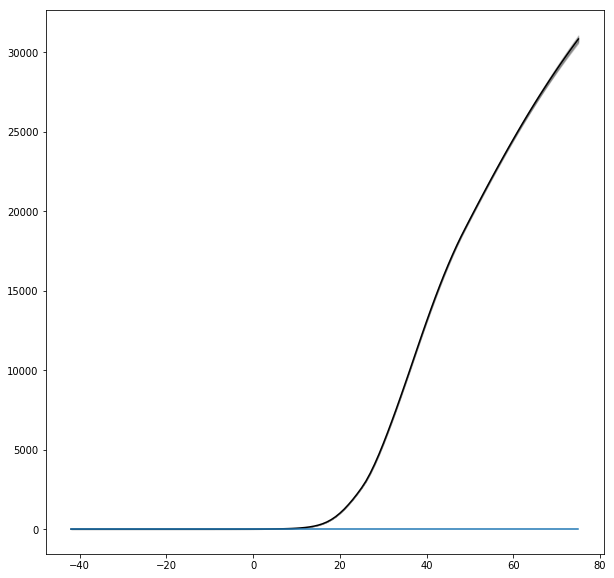

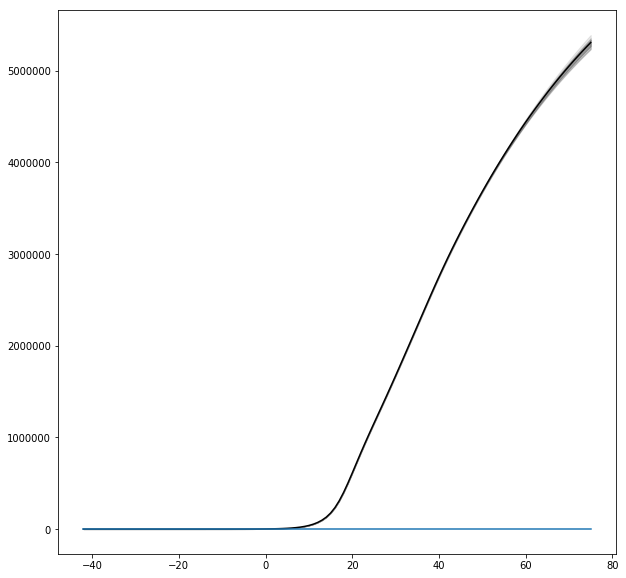

In [16]:
def myplot(name): 

    plt.figure(figsize=(10,10))
    
    samples = cm.get_chain(0).get_samples(name)[:,:]

    for i in np.arange(1, nChains):
        samples = np.vstack((samples, cm.get_chain(i).get_samples(name)[:,:]))
    
    
    y = np.median(samples,0)
    lower1 = np.percentile(samples, (100-68.27)/2, axis=0)
    lower2 = np.percentile(samples, (100-95.45)/2, axis=0)
    lower3 = np.percentile(samples, (100-99.73)/2, axis=0)
    upper1 = np.percentile(samples, 100-(100-68.27)/2, axis=0)
    upper2 = np.percentile(samples, 100-(100-95.45)/2, axis=0)
    upper3 = np.percentile(samples, 100-(100-99.73)/2, axis=0)
    
    time_all = np.arange(deaths_past.size+nPredictDays)-maxdelay
    
    
    plt.plot(time_all, y, 'k')
    fc = '#333333'
    ec = fc # '#000000'

    plt.plot(time_all,np.ones(time_all.shape))
    plt.fill_between(time_all, lower1, upper1, alpha=0.3, facecolor=fc, edgecolor=ec, antialiased=True)
    plt.fill_between(time_all, lower2, upper2, alpha=0.2, facecolor=fc, edgecolor=ec, antialiased=True)
    plt.fill_between(time_all, lower3, upper3, alpha=0.1, facecolor=fc, edgecolor=ec, antialiased=True)
    plt.show()
    
myplot("mild")
myplot("serious")
myplot("R")
myplot("dead")
myplot("recovered")